In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/IFT6390/Kaggle/Kaggle1"
os.chdir(path)

import numpy as np
import pandas as pd
from pandas import Series
from scipy.sparse import csr_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Data Preprocessing**

Train data

In [2]:
data = pd.read_csv('train.csv') 

# check missing values
# print(data.isnull().sum(axis=0))

data = data.drop('S.No', axis = 1) 
# print(data.duplicated()) check duplicate
data = data.drop_duplicates() #deduplicate

features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS',	'TREFHT',	'Z1000', 'Z200', 'ZBOT']
label = 'LABELS'
data_features = data[features]
data_label = data[label]

#month
month = data['time'].tolist()
for i in range(len(month)):
  month[i] = (month[i] % 10000) // 100
data_features.insert(data_features.shape[1], 'month', month)

#day
day = data['time'].tolist()
for i in range(len(day)):
  day[i] = day[i] % 100
data_features.insert(data_features.shape[1], 'day', day)

#standardization: Normalize train set to mean 0 and standard deviation 1 feature-wise.
mu = data_features.mean()
sigma  = data_features.std()
data_features = (data_features - mu)/sigma

# insert a column of 1s for the bias
data_features.insert(data_features.shape[1], 'BIAS', 1)
data_features.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,month,day,BIAS
0,-0.908686,-0.655686,-1.446629,-0.572219,1.037355,-0.713554,1.695781,-1.001604,1.394119,1.392846,1.962688,-0.686451,-0.168176,-0.662828,-0.849857,1.434832,-0.396766,-0.922959,0.136821,-1.272931,1
1,1.216774,0.193733,0.984026,1.298239,2.045043,1.076641,2.149791,1.041804,-1.377296,-1.383923,1.432447,1.332695,-0.193809,1.115359,1.439154,-1.493233,1.273084,1.402851,0.964361,-1.055355,1
2,1.216774,0.171380,-1.787944,-0.298059,-1.361854,-0.243334,-1.104079,-1.697052,0.591978,0.589156,-0.437588,-1.299803,-0.193809,0.432000,-0.840439,0.569268,-1.383491,-1.076930,-1.932029,1.664350,1
3,0.764985,-0.394900,1.395829,0.080610,-0.318709,0.940007,-0.334766,1.110756,-1.338133,-1.344684,0.632722,0.852439,0.183366,0.885178,0.783078,-1.463771,0.655926,0.844398,0.550591,-1.055355,1
4,-0.898418,-0.678039,-0.885710,-1.014248,-1.162562,-1.228055,-0.851582,-0.656311,1.808368,1.807895,-1.123181,-0.200704,-0.169139,-0.611811,-0.409376,1.916569,-0.204134,-0.446988,0.550591,-1.055355,1


Test data

In [3]:
test = pd.read_csv('test.csv')
features = ['lat', 'lon','TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS',	'TREFHT',	'Z1000', 'Z200', 'ZBOT']
test_features = test[features]

#month
month = test['time'].tolist()
for i in range(len(month)):
  month[i] = (month[i] % 10000) // 100
test_features.insert(test_features.shape[1], 'month', month)

#day
day = test['time'].tolist()
for i in range(len(day)):
  day[i] = day[i] % 100
test_features.insert(test_features.shape[1], 'day', day)


mu = test_features.mean()
sigma  = test_features.std()
test_features = (test_features - mu)/sigma
test_features.insert(test_features.shape[1], 'BIAS', 1)
test_features.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,month,day,BIAS
0,-1.229333,2.042784,-0.983297,-0.193739,-0.123017,-0.825821,-0.358298,-1.410598,2.021822,2.022854,-0.431612,-1.498500,-0.106353,-1.929845,-1.795646,2.010704,-1.765335,-1.731259,0.848069,1.30439,1
1,-1.229333,2.050397,-1.042802,-0.202247,-0.031383,-0.928823,-0.172188,-1.482267,2.033150,2.034209,-0.465811,-1.481222,-0.204784,-1.930019,-1.828771,2.017855,-1.765385,-1.777682,0.848069,1.30439,1
2,-1.229333,2.058010,-1.118994,-0.211497,0.042045,-0.988242,0.047758,-1.525559,2.051553,2.052655,-0.567847,-1.472340,-0.223318,-1.930019,-1.882917,2.031197,-1.755198,-1.838255,0.848069,1.30439,1
3,-1.229333,2.065623,-1.154444,-0.211198,0.134985,-0.978184,0.269036,-1.565374,2.055933,2.057046,-0.671754,-1.449615,-0.272138,-1.914115,-1.934666,2.030726,-1.747432,-1.896030,0.848069,1.30439,1
4,-1.229333,2.073235,-1.180665,-0.201475,0.295448,-0.934087,0.464976,-1.616486,2.045002,2.046088,-0.717009,-1.405900,-0.271125,-1.907302,-1.941000,2.018313,-1.743070,-1.910669,0.848069,1.30439,1


One Hot Labels

In [4]:
#onehot labels
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX
    
#oneHotIt(data_label)

# **2. Softmax**

In [5]:
def softmax(x):
    orig_shape = x.shape
    tmp = np.max(x,axis=1) 
    x -= tmp.reshape((x.shape[0],1)) 
    x = np.exp(x) 
    tmp = np.sum(x, axis = 1)        
    x /= tmp.reshape((x.shape[0], 1))
    return x

# **3. Cost Function**

In [6]:
def cost(w,x,y): #x:features，y:labels, w:weight
  m = np.shape(x)[0]
  y_mat = oneHotIt(y)
  scores = np.dot(x, w.T)
  probs = softmax(scores) #the probability of each label
  cost = (-1 / m) * np.sum(y_mat * np.log(probs)) + (lam/2)*np.sum(w*w)
  return probs, cost

# **4. Gradient Descent**

In [7]:
def J(theta, X_b, y):
  y_hat = softmax(np.dot(X_b, theta.T))
  return - np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)) / len(y)

def dJ(theta, X_b, y):
  return np.dot(X_b.T, softmax(np.dot(X_b, theta.T)) - y) / len(X_b)

def gradient_descent(X_b, y, initial_theta, eta, n_iters=1000, epsilon=1e-8):
  theta = initial_theta 
  cur_iter = 0
  y_mat = oneHotIt(y) 
  cost_array = []
  while cur_iter < n_iters:
    probs, loss = cost(theta, X_b, y)
    gradient = dJ(theta, X_b, y_mat)
    last_theta = theta
    theta = theta - eta * gradient.T
    if ((abs(J(theta, X_b, y_mat) - J(last_theta, X_b, y_mat)) < epsilon) and loss - cost_array[-1] > 0):
      break
    cur_iter += 1
    cost_array.append(loss)
  print(cost_array[-1])
  return theta, cost_array

# 5. Predict and visualize

In [8]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w.T))
    preds = np.argmax(probs,axis=1)
    return probs,preds
def getAccuracy(someX,someY):
    prob,prede = getProbsAndPreds(someX)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy

0.5049390927749103


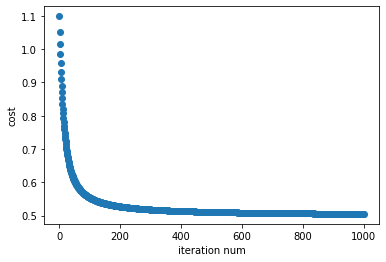

Training Accuracy:  0.7778985366611031


In [9]:
import matplotlib.pyplot as plt
w = np.zeros((3,21)) # initialization  
lam = 0
w, all_cost = gradient_descent(data_features, data_label, w, 0.1) 
def plotloss(loss_array):
    n = len(loss_array)
    plt.xlabel("iteration num")
    plt.ylabel("cost")
    plt.scatter(range(1, n+1), loss_array)
    plt.show()
plotloss(all_cost)
print('Training Accuracy: ', getAccuracy(data_features,data_label))

In [13]:
_,pred = getProbsAndPreds(test_features)
res=pd.DataFrame(pred, columns = ['LABELS'])
res.to_csv("result_LF.csv") 